In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.primitives import EstimatorV2
from ldpc import BpOsdDecoder
from qiskit import transpile
import stac
from qiskit import QuantumRegister


In [3]:
import numpy as np

def generate_unicycle_ldpc(m, n):
    """
    Generate a unicycle LDPC code.
    Parameters:
        m: Number of rows (check bits).
        n: Number of columns (code bits).
    Returns:
        Hx, Hz: LDPC parity-check matrices for X and Z errors.
    """
    H = np.random.randint(0, 2, (m, n))
    Hx = H
    Hz = H[:, ::-1]  # Reverse the columns for unicycle codes
    return Hx, Hz

def rand_bin_array(K, N):
    arr = np.zeros(N)
    arr[:K]  = 1
    np.random.shuffle(arr)
    return arr

def cyclic_shift_matrix(arr):
    N = len(arr)
    matrix = np.zeros((N, N), dtype=arr.dtype)  # Create a matrix of size N x N
    for i in range(N):
        matrix[i] = np.roll(arr, i)  # Shift the array by i positions
    return matrix

def generate_bicycle_ldpc_1(n, m, k):
    n_sub = int(n/2)
    row = rand_bin_array(k, n_sub)
    c = cyclic_shift_matrix(row)
    return np.concatenate((c, c.T), axis=1)

def add_random_x(circuit, p, n):
    """
    Randomly applies an X gate to each qubit in the quantum circuit with probability p.
    
    Parameters:
    - circuit (QuantumCircuit): The quantum circuit to modify.
    - p (float): The probability of applying an X gate to each qubit.
    """
    num_qubits = n
    log = np.zeros(n).astype(int)
    # For each qubit in the circuit, apply an X gate with probability p
    for qubit in range(num_qubits):
        if np.random.random() < p:  # With probability p, apply the X gate
            circuit.append("X", qubit)  # Apply X gate to the qubitcirc.append('Z', 4)
            log[qubit] = 1
    return log
            
def add_random_z(circuit, p, n):
    """
    Randomly applies an Z gate to each qubit in the quantum circuit with probability p.
    
    Parameters:
    - circuit (QuantumCircuit): The quantum circuit to modify.
    - p (float): The probability of applying an z gate to each qubit.
    """
    num_qubits = n
    log = np.zeros(n).astype(int)
    # For each qubit in the circuit, apply a z gate with probability p
    for qubit in range(num_qubits):
        if np.random.random() < p:  # With probability p, apply the z gate
            circuit.append("Z", qubit)  # Apply z gate to the qubit
            log[qubit] = 1
        
    return log

In [15]:
###THESE WORK. 
Hx = np.array([[1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0],
               [1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
               [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1],
               [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0],
               [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
               [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]])

Hz = np.array([[1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0],
               [1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
               [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1],
               [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0],
               [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
               [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]])

# USE BICYCLE PARITY CHECK MATRICES
#Hx = generate_bicycle_ldpc_1(12, 3, 3)
#Hz = Hx

check_orthogonality = np.mod(np.dot(Hx, Hz.T), 2)


zeros = np.zeros(Hx.shape)

rank = np.linalg.matrix_rank(Hx)

print(Hx)
print(Hz)
print(check_orthogonality)
print(rank)

[[1 0 0 1 0 1 1 1 0 1 0 0]
 [1 1 0 0 1 0 0 1 1 0 1 0]
 [0 1 1 0 0 1 0 0 1 1 0 1]
 [1 0 1 1 0 0 1 0 0 1 1 0]
 [0 1 0 1 1 0 0 1 0 0 1 1]
 [0 0 1 0 1 1 1 0 1 0 0 1]]
[[1 0 0 1 0 1 1 1 0 1 0 0]
 [1 1 0 0 1 0 0 1 1 0 1 0]
 [0 1 1 0 0 1 0 0 1 1 0 1]
 [1 0 1 1 0 0 1 0 0 1 1 0]
 [0 1 0 1 1 0 0 1 0 0 1 1]
 [0 0 1 0 1 1 1 0 1 0 0 1]]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
6


In [16]:
H0 = np.concatenate((np.concatenate((Hx, zeros), axis=1), np.concatenate((zeros, Hz), axis=1))) #in the standard form for a CSS code

In [17]:
H0.shape

(12, 24)

In [18]:
(512 - 174)/512

0.66015625

In [19]:
def get_stabilizers(H_sub, stab):
    all_stab = []
    for n in range(len(H_sub)):
        curr_str = ''
        row = H_sub[n]
        for m in row:
            if m:
                curr_str += stab
            else:
                curr_str += 'I'
        print(curr_str)
        all_stab.append(curr_str)
    return all_stab

In [20]:
get_stabilizers(Hx, 'X')

XIIXIXXXIXII
XXIIXIIXXIXI
IXXIIXIIXXIX
XIXXIIXIIXXI
IXIXXIIXIIXX
IIXIXXXIXIIX


['XIIXIXXXIXII',
 'XXIIXIIXXIXI',
 'IXXIIXIIXXIX',
 'XIXXIIXIIXXI',
 'IXIXXIIXIIXX',
 'IIXIXXXIXIIX']

In [21]:
def make_stabilizer_circ_1(Hx, Hz,  qc, noise_inject=None):
    """
    Generate a stabilizer circuit given Hx and Hz. 
    noise_inject: a list of functions which take in a qc and with probability p, adds a single pauli to each qubit. 
    ^The functions in noise_inject are shown in below example, and require error prob and number of data qubits
    as input (so the ancillas will not have errors). 
    
    """
    qc.barrier()
    data = qc.qregs[0]
    ancilla = qc.qregs[1]

    x_offset = 0
    z_offset = Hx.shape[0]
    
    for i in range(len(Hx)):
        row  = Hx[i]
        #print(row)
        for j in range(len(row)):
            curr = row[j]
            #print(curr)
            if curr:
                #print(i, j, curr)
                qc.cx(data[j], ancilla[i]) #need to track offset
                print(j, i)
                print("Added X stabilizer from qubit " + str(j) + " to ancilla " + str(i))
                qc.barrier()

    for i in range(len(Hz)):
        row  = Hz[i]
        #print(row)
        for j in range(len(row)):
            curr = row[j]
            #print(curr)
            if curr:
                #print(i, j, curr)
                print(j, i)
                qc.cz(data[j], ancilla[i + z_offset]) #need to track offset
                print("Added Z stabilizer from qubit " + str(j) + " to ancilla " + str(i+ z_offset))
                qc.barrier()

    #log where errors were added 
    logs = []
#     for f in noise_inject:
#         log = None
#         logs.append(log)
    #qc.x(10)
    print(ancilla)
    print(qc.cregs[0])
    qc.measure(ancilla, qc.cregs[0])
    if noise_inject:
        return qc, logs
    else:
        return qc

In [22]:
###ok, let's try for noisy simulation
# i removed params and replcaed it with None in pub

from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit import transpile
from qiskit.visualization import plot_histogram

#p = p

cd = stac.Code(np.concatenate((Hx, zeros)).astype(int), np.concatenate((zeros, Hz)).astype(int))

#cd = stac.Code(Hx.astype(int),Hz.astype(int))
#stac.print_matrix(cd.generator_matrix, augmented=True)
cd.construct_logical_operators()
cd.construct_standard_form()
#stac.print_matrix(cd.standard_generator_matrix, augmented=True)
#print("Logical X =", cd.logical_xs)
#print("Logical Z =", cd.logical_zs)

circ = cd.construct_encoding_circuit('non_ft')
circ.append('TICK')

# Step 2
# x_log = add_random_x(circ, p, Hx.shape[1])
# z_log = add_random_z(circ, p, Hx.shape[1])

# Step 3
cd.construct_syndrome_circuit()
circ += cd.syndrome_circuit

#circ.draw()
#         print(x_log)
#         print(z_log)

circ = QuantumCircuit.from_qasm_str(circ.qasm())

qc = circ

# Define the noise model
num_shots = 1
#noise_model = NoiseModel.from_backend("ibm_kyiv")
noise_model = NoiseModel()
cx_depolarizing_prob = 0.01

noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

# Define the sampler with the noise model
noisy_sampler = Sampler(
    options=dict(backend_options=dict(noise_model=noise_model))
)


# Transpile the circuit for the AerSimulator
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(3, simulator)
isa_circuit = pass_manager.run(qc)

# Submit the job to the noisy sampler
pub = (isa_circuit, None, num_shots)  # No params required
job = noisy_sampler.run([pub])

# Retrieve and display results
result = job.result()
pub_result = result[0]

# Retrieve and print counts
counts = pub_result.data.c.get_counts()
#print("Noisy simulation counts:")
#print(counts)
print(counts)

{'100110000000000000000000': 1}


In [24]:
N = 200
decoding_error_rates = []
ps = [0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.15, 0.2, 0.35, 0.5]

for p in ps:
    success_log = 0
    print("P: " + str(p))
    for n in range(N):
        # Hx = matrix3
        # Hz = Hx
        if n % 10 == 0:
            print("n: " + str(n))
        p = p

        cd = stac.Code(np.concatenate((Hx, zeros)).astype(int), np.concatenate((zeros, Hz)).astype(int))

        #cd = stac.Code(Hx.astype(int),Hz.astype(int))
        #stac.print_matrix(cd.generator_matrix, augmented=True)
        cd.construct_logical_operators()
        cd.construct_standard_form()
        #stac.print_matrix(cd.standard_generator_matrix, augmented=True)
        #print("Logical X =", cd.logical_xs)
        #print("Logical Z =", cd.logical_zs)

        circ = cd.construct_encoding_circuit('non_ft')
        circ.append('TICK')

        # Step 2
        x_log = add_random_x(circ, p, Hx.shape[1])
        z_log = add_random_z(circ, p, Hx.shape[1])

        # Step 3
        cd.construct_syndrome_circuit()
        circ += cd.syndrome_circuit

        #circ.draw()
#         print(x_log)
#         print(z_log)

        circ = QuantumCircuit.from_qasm_str(circ.qasm())

        qc = circ

        simulator = Aer.get_backend('qasm_simulator')
        transpiled_circuit = transpile(qc, backend=simulator)

        # Simulate the circuit
        job = simulator.run(transpiled_circuit, shots=1)
        result = job.result()
        counts = result.get_counts()

        # Display the measurement results
#         print("Measurement results:")
#         print(counts)

        x_success = False
        z_success = False

        bp_osd = BpOsdDecoder(
                    Hx,
                    error_rate = p,
                    bp_method = 'product_sum',
                    max_iter = 15,
                    schedule = 'serial',
                    osd_method = 'osd_cs', #set to OSD_0 for fast solve
                    osd_order = 2
                )

        pre_int_list = [int(bit) for bit in list(counts.keys())[0]][:Hx.shape[1]]
        int_list = pre_int_list[::-1][len(pre_int_list) // 2:]
        # Create a NumPy array
        syndrome = np.array(int_list)
        #syndrome = np.array([0,0,0,0,0,0,0,1])

#         print(f"Syndrome: {syndrome}")
#         print(f"Log: {x_log}")
        z_decoding = bp_osd.decode(syndrome)
#         print(f"Decoding: {z_decoding}")
        decoding_syndrome = Hx@z_decoding % 2


        bp_osd = BpOsdDecoder(
                    Hz,
                    error_rate = 0.05,
                    bp_method = 'product_sum',
                    max_iter = 15,
                    schedule = 'serial',
                    osd_method = 'osd_cs', #set to OSD_0 for fast solve
                    osd_order = 2
                )

        pre_int_list = [int(bit) for bit in list(counts.keys())[0]][:Hz.shape[1]]
        int_list = pre_int_list[::-1][:len(pre_int_list) // 2]
        syndrome = np.array(int_list)
        #syndrome = np.array([0,0,0,0,0,0,0,1])

#         print(f"Syndrome: {syndrome}")
#         print(f"Log: {z_log}")
        x_decoding = bp_osd.decode(syndrome)
#         print(f"Decoding: {x_decoding}")
        decoding_syndrome = Hz@x_decoding % 2

        x_success = np.array_equal(x_log, z_decoding)
        z_success = np.array_equal(z_log, x_decoding)

#         print("X success: " + str(x_success))
#         print("Z success: " + str(z_success))

        if x_success and z_success:
            success_log +=1
    success_ratio = success_log/N
    decoding_error_rates.append(success_ratio)

P: 0.01
n: 0
n: 10
n: 20
n: 30
n: 40
n: 50
n: 60
n: 70
n: 80
n: 90
n: 100
n: 110
n: 120
n: 130
n: 140
n: 150
n: 160
n: 170
n: 180
n: 190
P: 0.02
n: 0
n: 10
n: 20
n: 30
n: 40
n: 50
n: 60
n: 70
n: 80
n: 90
n: 100
n: 110
n: 120
n: 130
n: 140
n: 150
n: 160
n: 170
n: 180
n: 190
P: 0.03
n: 0
n: 10
n: 20
n: 30
n: 40
n: 50
n: 60
n: 70
n: 80
n: 90
n: 100
n: 110
n: 120
n: 130
n: 140
n: 150
n: 160
n: 170
n: 180
n: 190
P: 0.04
n: 0
n: 10
n: 20
n: 30
n: 40
n: 50
n: 60
n: 70
n: 80
n: 90
n: 100
n: 110
n: 120
n: 130
n: 140
n: 150
n: 160
n: 170
n: 180
n: 190
P: 0.05
n: 0
n: 10
n: 20
n: 30
n: 40
n: 50
n: 60
n: 70
n: 80
n: 90
n: 100
n: 110
n: 120
n: 130
n: 140
n: 150
n: 160
n: 170
n: 180
n: 190
P: 0.075
n: 0
n: 10
n: 20
n: 30
n: 40
n: 50
n: 60
n: 70
n: 80
n: 90
n: 100
n: 110
n: 120
n: 130
n: 140
n: 150
n: 160
n: 170
n: 180
n: 190
P: 0.1
n: 0
n: 10
n: 20
n: 30
n: 40
n: 50
n: 60
n: 70
n: 80
n: 90
n: 100
n: 110
n: 120
n: 130
n: 140
n: 150
n: 160
n: 170
n: 180
n: 190
P: 0.15
n: 0
n: 10
n: 20
n: 30
n: 40
n: 5

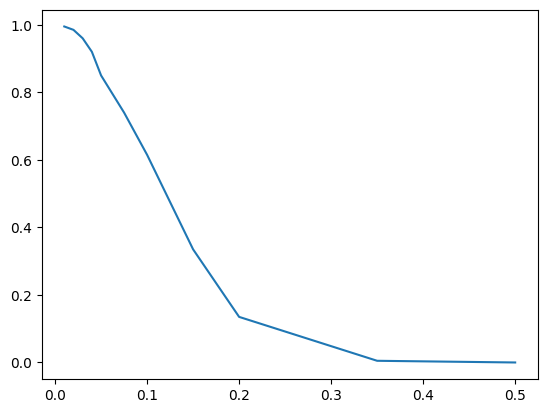

In [47]:
import matplotlib.pyplot as plt
plt.plot(ps, decoding_error_rates)

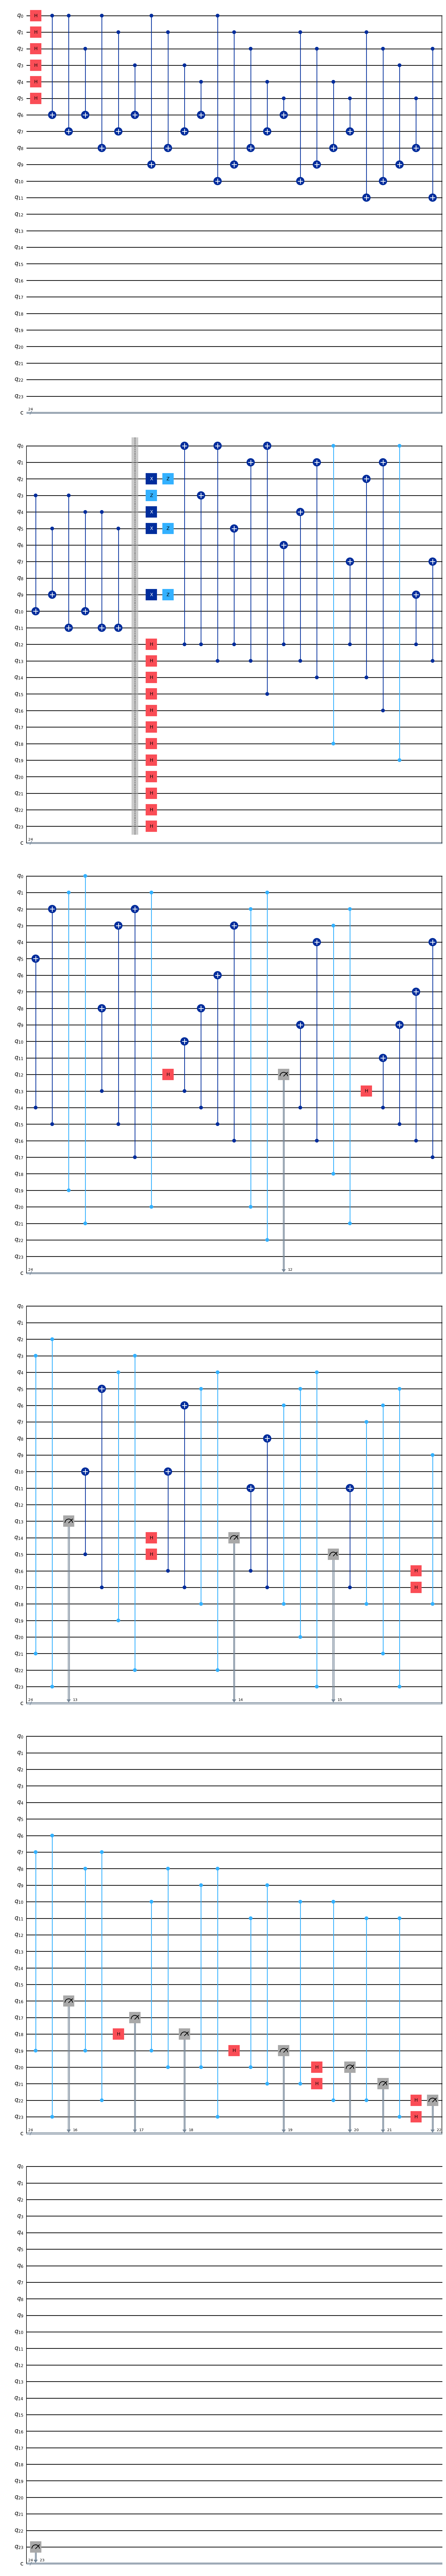

In [315]:
qc.draw(output='mpl')

{'000000000000000000000000': 10000}


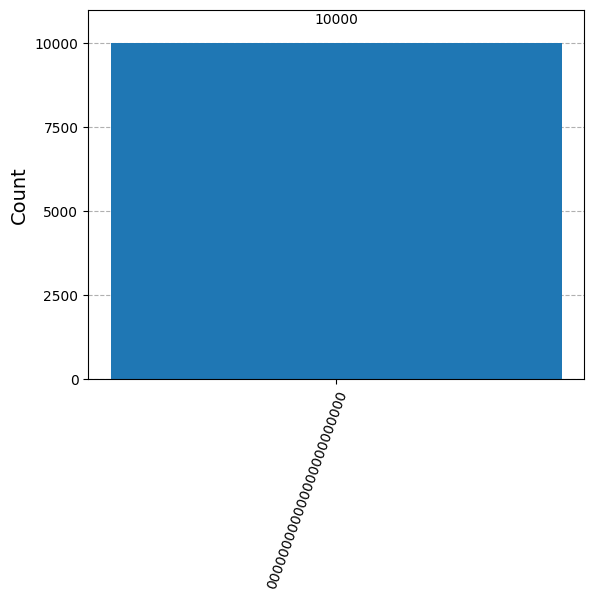

In [36]:
test_qc_for = QuantumCircuit.from_qasm_str(cd.construct_encoding_circuit('non_ft').qasm())
test_qc_inv = QuantumCircuit.from_qasm_str(cd.construct_encoding_circuit('non_ft').qasm()).inverse()
test_qc = test_qc_for.compose(test_qc_inv)
test_qc.measure([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(3, simulator)
isa_circuit = pass_manager.run(test_qc)


noise_model = NoiseModel()
cx_depolarizing_prob = 0.01

noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

# Define the sampler with the noise model
noisy_sampler = Sampler(
    options=dict(backend_options=dict(noise_model=noise_model))
)

# Submit the job to the noisy sampler
pub = (isa_circuit, None, 10000)  # No params required
job = noisy_sampler.run([pub])

# Retrieve and display results
result = job.result()
pub_result = result[0]

# Retrieve and print counts
ideal_counts = pub_result.data.c.get_counts()
#print("Noisy simulation counts:")
#print(counts)
print(ideal_counts)
plot_histogram(ideal_counts)

In [54]:
all_counts = []
for cx_p in [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]:
    print(cx_p)
    test_qc_for = QuantumCircuit.from_qasm_str(cd.construct_encoding_circuit('non_ft').qasm())
    test_qc_inv = QuantumCircuit.from_qasm_str(cd.construct_encoding_circuit('non_ft').qasm()).inverse()
    test_qc = test_qc_for.compose(test_qc_inv)
    test_qc.measure([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    simulator = AerSimulator()
    pass_manager = generate_preset_pass_manager(0, simulator)
    isa_circuit = pass_manager.run(test_qc)


    noise_model = NoiseModel()
    cx_depolarizing_prob = cx_p

    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
    )

    # Define the sampler with the noise model
    noisy_sampler = Sampler(
        options=dict(backend_options=dict(noise_model=noise_model))
    )

    # Submit the job to the noisy sampler
    pub = (isa_circuit, None, 2048)  # No params required
    job = noisy_sampler.run([pub])

    # Retrieve and display results
    result = job.result()
    pub_result = result[0]

    # Retrieve and print counts
    counts = pub_result.data.c.get_counts()
    #print("Noisy simulation counts:")
    #print(counts)
    #print(counts)
    all_counts.append(counts)
    #plot_histogram(counts)

0.001
0.005
0.01
0.02
0.05
0.1
0.2


In [55]:
from qiskit.quantum_info.analysis import hellinger_fidelity

In [56]:
fids = [hellinger_fidelity(c, ideal_counts) for c in all_counts]

In [57]:
fids

[0.9541015625000001,
 0.77880859375,
 0.572265625,
 0.32421875000000017,
 0.06835937500000015,
 0.002929687500000028,
 0.0004882812500000128]

Text(0.5, 0, 'Noise strength')

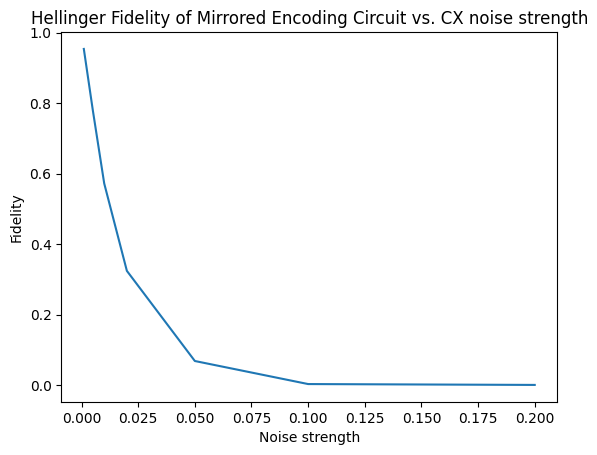

In [61]:
plt.plot([0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2], fids)
plt.title("Hellinger Fidelity of Mirrored Encoding Circuit vs. CX noise strength")
plt.ylabel("Fidelity")
plt.xlabel("Noise strength")

KeyboardInterrupt: 

In [82]:
from qiskit_ibm_runtime import QiskitRuntimeService
    
all_counts_backend_ata = []
for backend in ["ibm_brisbane", "ibm_kyiv", "ibm_cusco", "ibm_strasbourg", "ibm_nazca"]:
    print(backend)
    service = QiskitRuntimeService()
    backend = service.backend("ibm_brisbane")
    noise_model = NoiseModel.from_backend(backend)
    
    test_qc_for = QuantumCircuit.from_qasm_str(cd.construct_encoding_circuit('non_ft').qasm())
    test_qc_inv = QuantumCircuit.from_qasm_str(cd.construct_encoding_circuit('non_ft').qasm()).inverse()
    test_qc = test_qc_for.compose(test_qc_inv)
    test_qc.measure([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    simulator = AerSimulator()
    pass_manager = generate_preset_pass_manager(0, simulator)
    isa_circuit = pass_manager.run(test_qc)


    # noise_model = NoiseModel()
    # cx_depolarizing_prob = cx_p

    # noise_model.add_all_qubit_quantum_error(
    #     depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
    # )

    

    # Define the sampler with the noise model
    noisy_sampler = Sampler(
        options=dict(backend_options=dict(noise_model=noise_model))
    )

    # Submit the job to the noisy sampler
    pub = (isa_circuit, None, 2048)  # No params required
    job = noisy_sampler.run([pub])

    # Retrieve and display results
    result = job.result()
    pub_result = result[0]

    # Retrieve and print counts
    counts = pub_result.data.c.get_counts()
    #print("Noisy simulation counts:")
    #print(counts)
    #print(counts)
    all_counts_backend_ata.append(counts)
    #plot_histogram(counts)

ibm_brisbane
ibm_kyiv
ibm_cusco
ibm_strasbourg
ibm_nazca


In [86]:
[hellinger_fidelity(c, ideal_counts) for c in all_counts_backend_ata]

[0.65673828125,
 0.6806640625000001,
 0.681640625,
 0.6782226562500001,
 0.6791992187500001]

In [83]:
fids_backends = [hellinger_fidelity(c, ideal_counts) for c in all_counts_backend]
fids_backends_ata = [hellinger_fidelity(c, ideal_counts) for c in all_counts_backend_ata]

In [89]:
fids_backends_ata = [hellinger_fidelity(c, ideal_counts) for c in all_counts_backend_ata]
fids_backends_ata

[0.65673828125,
 0.6806640625000001,
 0.681640625,
 0.6782226562500001,
 0.6791992187500001]

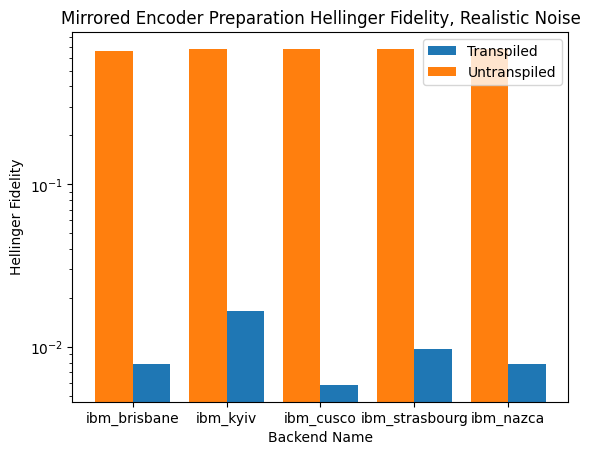

In [97]:
# plt.bar(["ibm_brisbane", "ibm_kyiv", "ibm_cusco", "ibm_strasbourg", "ibm_nazca"], fids_backends)
# plt.bar(["ibm_brisbane", "ibm_kyiv", "ibm_cusco", "ibm_strasbourg", "ibm_nazca"], fids_backends_ata)

X = ["ibm_brisbane", "ibm_kyiv", "ibm_cusco", "ibm_strasbourg", "ibm_nazca"]
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis + 0.2, fids_backends, 0.4, label = 'Transpiled') 
plt.bar(X_axis - 0.2, fids_backends_ata, 0.4, label = 'Untranspiled') 
  
plt.xticks(X_axis, X) 
plt.legend() 
plt.title("Mirrored Encoder Preparation Hellinger Fidelity, Realistic Noise")
plt.xlabel("Backend Name")
plt.ylabel("Hellinger Fidelity")
plt.yscale('log')
plt.show() 



In [76]:
#See how this would compile to a realistic topology

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.backend("ibm_kyiv")
pass_manager = generate_preset_pass_manager(
    optimization_level=0, backend=backend
)

In [77]:
transpiled = pass_manager.run(qc)

In [78]:
print("Gate counts before transpilation:")
print(dict(qc.count_ops()))
print("Gate counts after transpilation:")
print(dict(transpiled.count_ops()))

Gate counts before transpilation:
{'cx': 66, 'cz': 36, 'h': 30, 'measure': 12, 'z': 6, 'x': 5, 'barrier': 1}
Gate counts after transpilation:
{'rz': 5797, 'sx': 3209, 'ecr': 1035, 'x': 107, 'measure': 12, 'barrier': 1}
